# Project: PlotGEN

**Concept**

Why would we hard-code a plotline structure? My idea is to have the computer look at a text, discern important plot information from it, and construct its own story from that.

**Outline**
1. Compile texts from sources
    - Gutenberg
    - webscraper
    - manually copying and pasting
2. Analyze the texts
    - Characters
        - build frequency table of characters appearances
        - account for first / second person narration
        - the most frequently mentioned character is most likely the main character
    - Setting
        - use Wordnet to find locations
        - find descriptors of locations to apply as modifiers
3. Build plot structure for each text
    - Summarize each text?
    - Distill each sentence down to basic concepts
        - Example: "Michael walked along the sandy, desolate beach" -> "Michael walked beach" -> `[Michael, ACTION, SETTING]`
    - Using positve / negative word frequency to form a "plot-line"
4. Train unsupervised learning model on plot structures
    - Clustering in n-dimensional space
5. Generate plot structure using structures
    - Group it with closest cluster
    - Change aspect
    - Repeat until firmly within the cluster
6. Profit?

In [257]:
from nltk.corpus import gutenberg as gb
import matplotlib.pyplot as plt
import numpy as np
import random

In [256]:
# comment this line out if cloning from Github; the shrunkengooglevectors.bin file was too large to push
# wv_from_bin = KeyedVectors.load_word2vec_format("data\\shrunkengooglevectors.bin", binary=True)

---
### Text Retrieval
- Get the text(s)

In [3]:
# Read in Call of Cthulhu
f = open('data\\call_of_cthulhu', 'r', encoding="utf8")
cthulhu_str = f.read()
f.close()

In [4]:
# Read in Color Out of Space
f = open('data\\color_out_of_space.txt', 'r')
color_str = f.read()
f.close()

In [5]:
# Read in Shadow Over Innsmouth
f = open('data\\shadow_over_innsmouth.txt', 'r')
innsmouth_str = f.read()
f.close()

In [86]:
# Read in Shadow Out of Time
f = open('data\\shadow_out_of_time.txt', 'r')
time_str = f.read()
f.close()

In [6]:
# Read in A New Hope
f = open('data\\EpisodeIV_dialogues.txt', 'r')
starwarsIV = f.read()
f.close()

---
### Text Analysis (abandoned)
- Analyze the text(s)
- Get character list, main character, locations, etc
- Try to get general plotline structure

In [7]:
# # Get characters from text
# def get_chars(input_text_str):
#     # some of this code is taken from the spaCy tutorial
#     # Load English tokenizer, tagger, parser, NER and word vectors
#     nlp = en_core_web_sm.load()
#     text = (input_text_str)
#     doc = nlp(text)
    
#     entity_just_persons = set([entity.text for entity in doc.ents if entity.label_ == "PERSON"])
#     entity_good = [entity.text for entity in doc.ents if entity.label_ == "PERSON" or 
#                    (entity.label_ == "GPE" and entity.text in entity_just_persons)]
#     char_dict = {}
#     for ent_text in entity_good:
#         if ent_text in char_dict:
#             char_dict[ent_text] += 1
#         else:
#             char_dict[ent_text] = 1
#     char_list = [(key, char_dict[key]) for key in list(char_dict.keys()) if char_dict[key] > 1]
#     char_list.sort(key=lambda x: x[1], reverse=True)
#     return char_list

In [8]:
# # Build graph of sentence to sentence flow
# def build_sentence_graph(input_text_str, char_list):
#     char_dict = {}
#     for char in char_list:
#         char_dict[char[0]] = char[1]
    
#     paragraphs = input_text_str.split("\n")
    
#     char_sents = []
#     return char_sents

### Build plot structure
- Using positve / negative word frequency to form a "plot-line"

In [78]:
# Get structure of plot via sentiment analysis
def get_plot_struct(input_text_str):
    paragraphs = input_text_str.split("\n")
    tokenized_paras = []
    
    for paragraph in paragraphs:
        sentences = []
        if len(paragraph) < 2:
            continue
        token_para = tokenize.sent_tokenize(paragraph)
        for sentence in token_para:
            if len(sentence) < 5:
                continue
            token_sentence = tokenize.word_tokenize(sentence)
            sentences.append(token_sentence)
        if len(sentences) < 2:
            continue
        tokenized_paras.append(sentences)
    
    posf = open("data\\opinion-lexicon-English\\positive-words.txt", 'r')
    negf = open("data\\opinion-lexicon-English\\negative-words.txt", 'r')
    
    pos_words = posf.read()
    neg_words = negf.read()
    
    posf.close()
    negf.close()
    
    pos_set = set(pos_words.split("\n"))
    neg_set = set(neg_words.split("\n"))
    
    storyline = [[],[]]
    len_tokenized_paras = len(tokenized_paras)
    for i in range(len_tokenized_paras):
        para = tokenized_paras[i]
        total_pos = 0
        total_neg = 0
        total_sents = 0
        
        valid_para = False
        
        for sent in para:
            valid_sent = False
            points_pos = 0
            points_neg = 0
            
            for word in sent:
                if word in pos_set:
                    points_pos += 1
                    valid_sent = True
                    continue
                elif word in neg_set:
                    points_neg += 1
                    valid_sent = True
                    continue                
            
            if not valid_sent:
                continue
            
            total_sents += 1
            
            if points_pos > points_neg:
                total_pos += (points_pos)
            elif points_neg > points_pos:
                total_neg += (points_neg)
            
            if not valid_para and valid_sent:
                valid_para = True
        
        if not valid_para:
            continue
        
        storyline[0].append(float(i) * 100.0 / float(len_tokenized_paras))
        
        if total_pos > total_neg:
            storyline[1].append(total_pos/total_sents)
        elif total_neg > total_pos:
            storyline[1].append(-total_neg/total_sents)
        else:
            storyline[1].append(0.0)
    
    for i in range(len(storyline[1])):
        if i == 0 or i == len(storyline[1])-1:
            continue
                
        if storyline[1][i] == 0.0:
            storyline[1][i] = (storyline[1][i-1] + storyline[1][i+1]) / 2
            continue

        if storyline[1][i] > 0.0 and (storyline[1][i-1] < 0 and  storyline[1][i+1] < 0):
            storyline[1][i] = (storyline[1][i-1] + storyline[1][i+1]) / 2
        elif storyline[1][i] < 0.0 and (storyline[1][i-1] > 0 and  storyline[1][i+1] > 0):
            storyline[1][i] = (storyline[1][i-1] + storyline[1][i+1]) / 2
    
    max_value = max([abs(min(storyline[1])), abs(max(storyline[1]))])
    
    for i in range(len(storyline[1])):
        storyline[1][i] = storyline[1][i] / max_value
        
    return storyline

In [96]:
# Getting Average Values
def average_values(x_and_y):
    x_array = []
    y_array = []
    
    for i in range(len(x_and_y[1])):
        if i == 0:
            x_array.append(x_and_y[0][i])
            y_array.append((x_and_y[1][i]+x_and_y[1][i+1])/2)
        elif i == len(x_and_y[1])-1:
            x_array.append(x_and_y[0][i])
            y_array.append((x_and_y[1][i]+x_and_y[1][i-1])/2)
        else:
            x_array.append(x_and_y[0][i])
            y_array.append((x_and_y[1][i-1]+x_and_y[1][i]+x_and_y[1][i+1])/3)
    
    max_value = max([abs(min(y_array)),abs(max(y_array))])
    for i in range(len(y_array)):
        y_array[i] = y_array[i] / max_value
    
    
    return [x_array, y_array]

In [124]:
# Get mean shape of multiple texts
def mean_plot(plotlines):
    total_x = []
    total_y = {}
    
    for plot in plotlines:
        for i in range(len(plot[0])):
            if plot[0][i] in total_x:
                total_y[plot[0][i]].append(plot[1][i])
            else:
                total_y[plot[0][i]] = [plot[1][i]]
                total_x.append(plot[0][i])
                       
    avg_x = sorted(total_x)
    temp_y = [(arr, np.average(total_y[arr])) for arr in list(total_y.keys())]
    temp_y2 = sorted(temp_y, key=lambda tup: tup[0])
    avg_y = [tup[1] for tup in temp_y2]
    
    return [avg_x, avg_y]

### Plotlines in words
- some text generation based off the plotlines

In [253]:
# Get paragraph qualities
def para_qualities(input_plot):
    para_vals = []    
    ys = input_plot[1]
    len_ys = len(ys)
    biggest = max(abs(min(ys)),abs(max(ys)))    
    
    for i in range(len_ys):
        if i > 0 and i < len_ys-1:
            if abs(ys[i-1]) < abs(ys[i]) < abs(ys[i+1]):
                continue
            if abs(ys[i-1]) > abs(ys[i]) > abs(ys[i+1]):
                continue
        
        para_val = ""
        y_val = abs(ys[i])
        
        if y_val == 0.0:
            para_vals.append("neutral")
            continue
        
        if y_val < 0.25:
            para_val += "a little "
        elif y_val < 0.5:
            para_val += "kinda "
        elif y_val < 0.75:
            para_val += ""
        elif y_val < 1.0:
            para_val += "very "
        else:
            para_val += "most "
        
        if ys[i] < 0.0:
            para_val += "bad"
        elif ys[i] > 0.0:
            para_val += "good"
        
        para_vals.append(para_val)
    
    return para_vals
            

---
### Testing

['bad', 'bad', 'most bad', 'bad', 'bad', 'a little good', 'a little good', 'a little good', 'bad', 'bad', 'very bad', 'very bad']


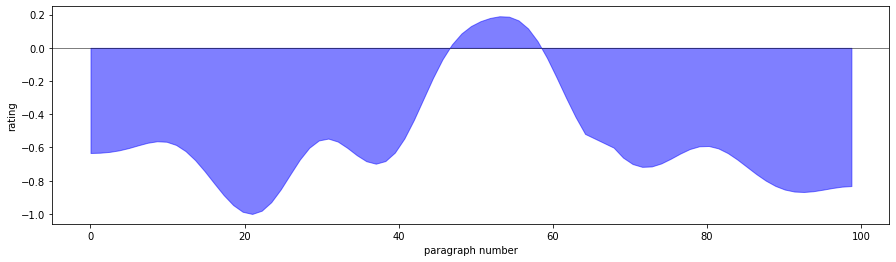

In [254]:
cthulhu_storyline = get_plot_struct(cthulhu_str)

cthulhu_moderated = cthulhu_storyline
for i in range(0,20):
    cthulhu_moderated = average_values(cthulhu_moderated)

cthulhu_plotline = para_qualities(cthulhu_moderated)
print(cthulhu_plotline)
plt.figure(figsize=(15,4))
#plt.plot(cthulhu_storyline[0], cthulhu_storyline[1], 'b-')

plt.fill_between(cthulhu_moderated[0], 0, cthulhu_moderated[1], color='b', alpha=0.5)
plt.axhline(linewidth=0.5, color='black')
plt.ylabel('rating')
plt.xlabel('paragraph number')
plt.show()

In [81]:
# EMMA
emma_str = gb.raw('austen-emma.txt')
emma_storyline = get_plot_struct(emma_str)

['pretty good', 'good', 'good', 'most good', 'very good', 'very good', 'good', 'good', 'a little bad', 'a little bad', 'a little good', 'good', 'good', 'good', 'pretty good', 'good', 'pretty good', 'good', 'pretty good', 'good', 'pretty good', 'good', 'a little good', 'a little good', 'a little good', 'a little bad', 'a little good', 'good']


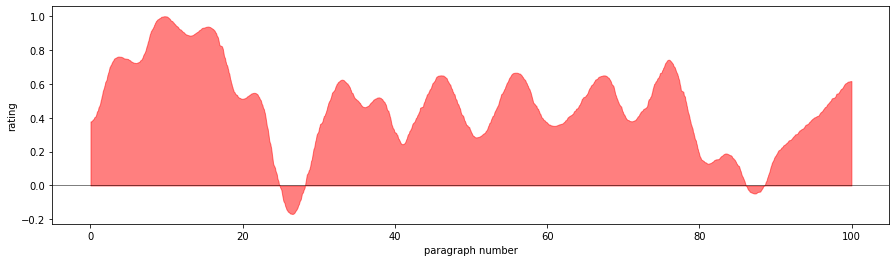

In [247]:
storyline_hundredth = shorten_storyline(emma_storyline, 80)                                  

emma_moderated = emma_storyline
for i in range(0,2000):
    emma_moderated = average_values(emma_moderated)

emma_plotline = para_qualities(emma_moderated)
print(emma_plotline)
    
plt.figure(figsize=(15,4))
#plt.plot(storyline_hundredth[0], storyline_hundredth[1], 'r-')
plt.fill_between(emma_moderated[0], 0, emma_moderated[1], color='r', alpha=0.5)
plt.axhline(linewidth=0.5, color='black')
plt.ylabel('rating')
plt.xlabel('paragraph number')
plt.show()

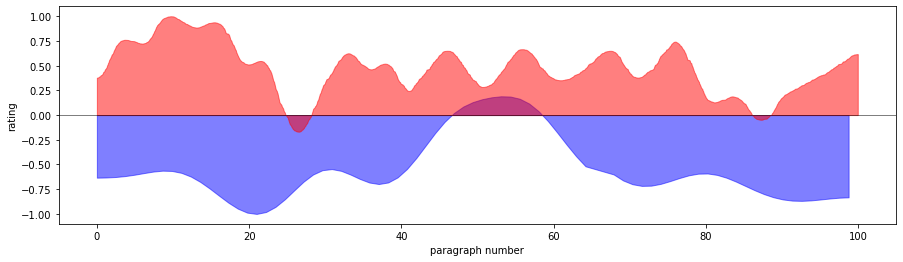

In [116]:
plt.figure(figsize=(15,4))
#plt.plot(storyline_hundredth[0], storyline_hundredth[1], 'r-')
#plt.plot(cthulhu_storyline[0], [pl/10 for pl in cthulhu_storyline[1]], 'b-')
plt.fill_between(cthulhu_moderated[0], 0, cthulhu_moderated[1], color='b', alpha=0.5)
plt.fill_between(emma_moderated[0], 0, emma_moderated[1], color='r', alpha=0.5)
plt.axhline(linewidth=0.5, color='black')
plt.ylabel('rating')
plt.xlabel('paragraph number')
plt.show()

In [87]:
# Comparing multiple Lovecraft texts
color_storyline = get_plot_struct(color_str)
innsmouth_storyline = get_plot_struct(innsmouth_str)
time_storyline = get_plot_struct(time_str)

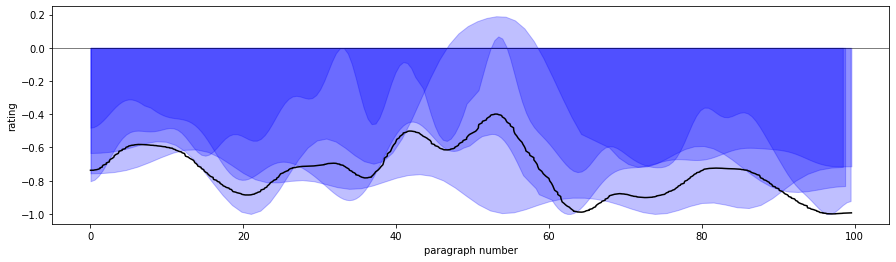

In [210]:
color_moderated = color_storyline
for i in range(0,10):
    color_moderated = average_values(color_moderated)

innsmouth_moderated = innsmouth_storyline
for i in range(0,100):
    innsmouth_moderated = average_values(innsmouth_moderated)

time_moderated = time_storyline
for i in range(0,20):
    time_moderated = average_values(time_moderated)
    
plt.figure(figsize=(15,4))

plt.fill_between(innsmouth_moderated[0], 0, innsmouth_moderated[1], color='b', alpha=0.25)
plt.fill_between(color_moderated[0], 0, color_moderated[1], color='b', alpha=0.25)
plt.fill_between(cthulhu_moderated[0], 0, cthulhu_moderated[1], color='b', alpha=0.25)
plt.fill_between(time_moderated[0], 0, time_moderated[1], color='b', alpha=0.25)

average_lovecraft = mean_plot([cthulhu_moderated,color_moderated,innsmouth_moderated,time_moderated])
lovecraft_moderated = average_lovecraft
for i in range(0,100):
    lovecraft_moderated = average_values(lovecraft_moderated)
    
plt.plot(lovecraft_moderated[0], lovecraft_moderated[1], 'k-')
plt.axhline(linewidth=0.5, color='black')
plt.ylabel('rating')
plt.xlabel('paragraph number')
plt.show()

In [239]:
# Random noise using numpy
mu, sigma = 0, 0.5
moderated_list = cthulhu_moderated
len_lovecraft = len(moderated_list[1])
noise = np.random.normal(mu, sigma, [len_lovecraft]) 
new_lovecraft = [moderated_list[0],[moderated_list[1][i]+noise[i] for i in range(0,len_lovecraft)]]

['very bad', 'bad', 'very bad', 'a little good', 'kinda good', 'a little bad', 'most bad', 'very bad']


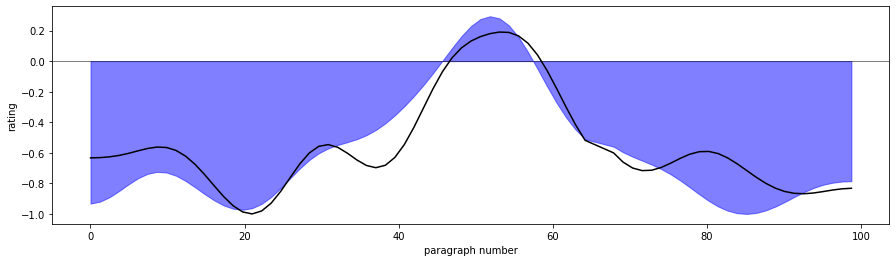

In [255]:
new_moderated = new_lovecraft
for i in range(0,20):
    new_moderated = average_values(new_moderated)

new_moderated_qualities = para_qualities(new_moderated)
print(new_moderated_qualities)

plt.figure(figsize=(15,4))
plt.fill_between(new_moderated[0], 0, new_moderated[1], color='b', alpha=0.5)
plt.plot(moderated_list[0], moderated_list[1], 'k-')

plt.axhline(linewidth=0.5, color='black')
plt.ylabel('rating')
plt.xlabel('paragraph number')
plt.show()

### Just for fun
A bit of Star Wars, just for fun :)

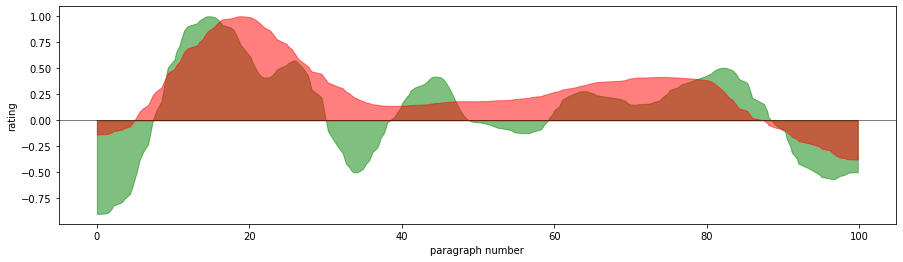

In [238]:
# Star Wars
starwarsIV_storyline = get_plot_struct(starwarsIV)

starwarsIV_moderated = starwarsIV_storyline
for i in range(0,100):
    starwarsIV_moderated = average_values(starwarsIV_moderated)
    
starwarsIV_more_moderated = starwarsIV_storyline
for i in range(0,1000):
    starwarsIV_more_moderated = average_values(starwarsIV_more_moderated)

plt.figure(figsize=(15,4))

plt.fill_between(starwarsIV_moderated[0], starwarsIV_moderated[1], color='g', alpha=0.5)
plt.fill_between(starwarsIV_more_moderated[0], starwarsIV_more_moderated[1], color='r', alpha=0.5)

plt.axhline(linewidth=0.5, color='black')
plt.ylabel('rating')
plt.xlabel('paragraph number')
plt.show()

Interesting note: The ending of _A New Hope_ is seen by the program as negative. This is because it cannot recognize the difference between heroes and villains. At the end of the movie, the Death Star is destroyed, but the program sees that as a negative because of words like "battle", "destruction", "explosion", etc.